In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.io as spio
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

In [2]:
#Read splicing data

df = pd.read_csv('Splicing_Data.txt', sep='\t')
df = df.loc[~np.isnan(df.SD1_Usage)].copy().reset_index(drop=True)

df = df.iloc[-10000:].copy().reset_index(drop=True)

df['Region1'] = df['Seqs'].str.slice(2, 37)

print('Size of splicing dataset = ' + str(len(df)))

Size of splicing dataset = 10000


In [3]:
# Generate 6mer feature matrix

mer6_dict = {}
mer6_list = []
bases = list('ACGT')

#Build dictionary of 6-mer -> index
i = 0
for b1 in bases :
    for b2 in bases :
        for b3 in bases :
            for b4 in bases :
                for b5 in bases :
                    for b6 in bases :
                        mer6_dict[b1 + b2 + b3 + b4 + b5 + b6] = i
                        mer6_list.append(b1 + b2 + b3 + b4 + b5 + b6)
                        i += 1

#Loop over dataframe, fill matrix X with 6-mer counts
X = sp.lil_matrix((len(df), len(mer6_dict)))
for index, row in df.iterrows() :
    if index % 2000 == 0 :
        print('Extracting 6-mer features from sequence ' + str(index))
    
    region1 = row['Region1']
    #Loop over all 6-mers in the current sequence
    for j in range(0, len(region1) - 6 + 1) :
        if region1[j:j+6] in mer6_dict :
            #Increment X at the corrposnding 6-mer index position
            X[index, mer6_dict[region1[j:j+6]]] += 1.

X = sp.csr_matrix(X)
y = np.ravel(df['SD1_Usage'].values)

print('Shape of X = ' + str(X.shape))
print('Shape of y = ' + str(y.shape))


Extracting 6-mer features from sequence 0
Extracting 6-mer features from sequence 2000
Extracting 6-mer features from sequence 4000
Extracting 6-mer features from sequence 6000
Extracting 6-mer features from sequence 8000
Shape of X = (10000, 4096)
Shape of y = (10000,)


In [268]:
# Problem 1.1
# Calculate log odds ratios of 6-mers using feature matrix X and splicing ratios y

X_col = sp.csc_matrix(X) # More efficient representation of X when working with columns

print(X_col.shape)
print(X_col[4, :].size)
print(X_col[4, :])

(10000, 4096)
28
  (0, 0)	1.0
  (0, 2)	2.0
  (0, 10)	2.0
  (0, 40)	1.0
  (0, 42)	1.0
  (0, 162)	1.0
  (0, 170)	1.0
  (0, 608)	1.0
  (0, 650)	1.0
  (0, 682)	1.0
  (0, 694)	1.0
  (0, 1024)	1.0
  (0, 1536)	1.0
  (0, 2026)	1.0
  (0, 2048)	1.0
  (0, 2200)	1.0
  (0, 2221)	1.0
  (0, 2304)	1.0
  (0, 2432)	1.0
  (0, 2598)	1.0
  (0, 2603)	1.0
  (0, 2624)	1.0
  (0, 2697)	1.0
  (0, 2704)	1.0
  (0, 2724)	1.0
  (0, 2729)	1.0
  (0, 3746)	1.0
  (0, 4008)	1.0


In [188]:
def safe_kl_log(num, denom):
    log_vec = np.zeros(num.shape)
    log_vec[(num > 0) & (denom > 0)] = np.log(num[(num > 0) & (denom > 0)] / denom[(num > 0) & (denom > 0)])
    return log_vec

In [274]:
logodds_ratios = np.zeros(X_col.shape[1])
y_has = np.zeros(X_col.shape[1])
y_not = np.zeros(X_col.shape[1])

# print(logodds_ratios.shape)
# print(X[1, :])
# print(y[X[1, :])
        
# Loop over every 6-mer index
for w_i in range(logodds_ratios.shape[0]) :
    if w_i % 1000 == 0:
        print('Calculating logodds for 6-mer ' + str(w_i) + '...')
#     cols = []
#     out_ind = np.transpose()
#     for arr in out_ind:
#         cols.append(arr[1])
        
    y_has_mul = np.nonzero(X[:, w_i])[0]
    y_not_mul = np.where(np.sum(X[:, w_i], axis = 1) == 0)[0]
    
    y_has[w_i] = np.sum(y[y_has_mul]) / X_col[:, w_i].size
    y_not[w_i] = (np.sum(y) - np.sum(y[y_has_mul])) / (10000 - X_col[:, w_i].size)
#     print(y_not[0])
    
    if(y_has[w_i] == 0 or y_not[w_i] == 0):
        logodds_ratios[w_i] = 0
        continue
    num = y_has[w_i] / (1 - y_has[w_i])
    denum = y_not[w_i] / (1 - y_not[w_i])
    logodds_ratios[w_i] = np.log(num / denum)
    
    #TODO: Calculate and store the log odds ratio of each 6-mer in vector 'logodds_ratios'

Calculating logodds for 6-mer 0...
Calculating logodds for 6-mer 1000...


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


Calculating logodds for 6-mer 2000...
Calculating logodds for 6-mer 3000...
Calculating logodds for 6-mer 4000...


In [275]:
print(max(logodds_ratios))
print(min(logodds_ratios))

4.038562322892769
-4.3735585338842755


[-4.37355853 -4.10546135 -4.0484051  ...         nan         nan
         nan]


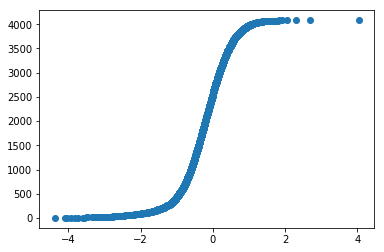

In [276]:
#Problem 1.1
#TODO: Plot the sorted Log odds ratios, and print the smallest and largest values
ind = np.argsort(logodds_ratios)
logodds_ratios.sort()
print(logodds_ratios)
ind.sort()
plt.scatter(logodds_ratios, ind)

In [210]:
#Problem 1.3
#TODO: Split data (matrix X and vector y) into training and test sets. Test set should contain 2,000 data points


In [148]:
# Problem 1.3
# TODO: Implement Gradient Descent with KL-divergence gradients for regressing splice site usages

# Helper function for computing log(x / y) in a safe way (whenever x or y is 0).


# Compute the KL divergence loss (alpha is regularization parameter)
def kl_divergence_loss(X, w, w_0, y_true, alpha = 0.0001) :
    # Return kl divergence loss function
    y_hat = 1 / (1 + np.exp(-(w_0 + X * w)))
#     print(y_hat)
    N = X.shape[0]
    bla = safe_kl_log(y_true, y_hat)
    first_term = np.sum(y_true * safe_kl_log(y_true, y_hat)) / N
    second_term = np.sum((1 - y_true) * safe_kl_log(1 - y_true, 1 - y_hat)) / N
    return first_term + second_term + 1/2 * alpha * np.sum(w * w) 

# Compute the KL divergence gradients for the weight vector w and intercept term w_0 (alpha is regularization parameter)
def kl_divergence_gradients(X, w, w_0, y_true, alpha = 0.0001) :
    # Return kl divergence loss gradients for w and w_0
    N = X.shape[0]
    y_hat = 1 / (1 + np.exp(-(w_0 + X * w)))
    w_new_gradient = X.T *(y_hat - y_true) / N + alpha * w
    w_0_new_gradient = np.sum((y_hat - y_true)) / N
    return w_new_gradient, w_0_new_gradient

# Gradient Descent algorithm to optimize weights w and w_0
def gradient_descent(X_train, y_train, X_test, y_test, w, w_0, step_size = 0.1, alpha = 0.0001, max_epochs = 3000):# 2000):
    mean_train_losses = []
    mean_test_losses = []
    for epoch in range(max_epochs) : # Stop after unreasonable # of iterations, in case we never converge
        if epoch % 50 == 1 and len(mean_train_losses) > 0 :
            print('Training epoch = ' + str(epoch))
            print('Training set KL-div = ' + str(round(mean_train_losses[-1], 4)))
            print('Test set KL-div = ' + str(round(mean_test_losses[-1], 4)))
        
        # Calculate the KL loss and gradients on the training set
        KL_loss_train = kl_divergence_loss(X_train, w, w_0, y_train, alpha)
        KL_loss_test = kl_divergence_loss(X_test, w, w_0, y_test, alpha)
        
        w_new_gradient, w_0_new_gradient = kl_divergence_gradients(X_train, w, w_0, y_train, alpha)
        
        # Update your weights w and w_0 based on the gradients
        w = w - step_size * w_new_gradient
        w_0 = w_0 - step_size * w_0_new_gradient
        
        # Append your mean train and test loss to 'mean_train_losses' and 'mean_test_losses'
        mean_train_losses.append(KL_loss_train)
        mean_test_losses.append(KL_loss_test)
        # Stop the loop once the training loss stops decreasing significantly
        if(epoch > 0):
            if ((mean_train_losses[-2] / mean_train_losses[-1]) < (1 + alpha)):
                print("Breaks at epoch: " + str(epoch))
                break
    
    print('Gradient descent completed.')
    print('Final training set KL-div = ' + str(round(mean_train_losses[-1], 4)))
    print('Final test set KL-div = ' + str(round(mean_test_losses[-1], 4)))
    
    return w, w_0, mean_train_losses, mean_test_losses

In [149]:
print(X.shape)
print(y.shape)
trainingSamples = 8000
X_train = X[0:trainingSamples, :]
y_train = y[0:trainingSamples]
X_test = X[trainingSamples:, :]
y_test = y[trainingSamples:]
print(X_test.shape)
print(y_test.shape)
w, w_0 = np.zeros(X_train.shape[1]), 0
print(kl_divergence_loss(X_train, w, w_0, y_train))

(10000, 4096)
(10000,)
(2000, 4096)
(2000,)
0.4482165671312173


In [277]:
# Problem 1.3
# Here we initialize the weight vector and intercept term to zeros.
w, w_0 = np.zeros(X.shape[1]), 0

# Train the weights using your Gradient Descent algorithm
w, w_0, train_losses, test_losses = gradient_descent(X_train, y_train, X_test, y_test, w, w_0)


Training epoch = 1
Training set KL-div = 0.4482
Test set KL-div = 0.4385
Training epoch = 51
Training set KL-div = 0.25
Test set KL-div = 0.2597
Training epoch = 101
Training set KL-div = 0.2233
Test set KL-div = 0.2351
Training epoch = 151
Training set KL-div = 0.2064
Test set KL-div = 0.2192
Training epoch = 201
Training set KL-div = 0.1943
Test set KL-div = 0.2081
Training epoch = 251
Training set KL-div = 0.1851
Test set KL-div = 0.1999
Training epoch = 301
Training set KL-div = 0.1777
Test set KL-div = 0.1934
Training epoch = 351
Training set KL-div = 0.1716
Test set KL-div = 0.1881
Training epoch = 401
Training set KL-div = 0.1665
Test set KL-div = 0.1837
Training epoch = 451
Training set KL-div = 0.162
Test set KL-div = 0.18
Training epoch = 501
Training set KL-div = 0.1581
Test set KL-div = 0.1767
Training epoch = 551
Training set KL-div = 0.1547
Test set KL-div = 0.1739
Training epoch = 601
Training set KL-div = 0.1516
Test set KL-div = 0.1713
Training epoch = 651
Training set

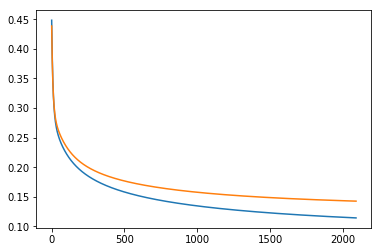

In [153]:
#Problem 1.3
#TODO: Plot training and test set loss (mean KL-div) vs. training iteration
plt.plot(train_losses)
plt.plot(test_losses)
#TODO: Scatter plot of true vs. pred SD1 usage on test set, and print R^2 coefficient.


(0.709624386944727, 3.6756038949483877e-306)


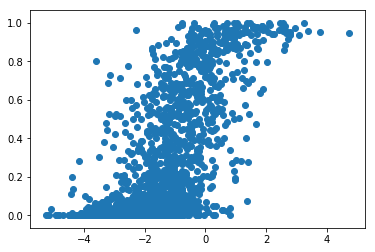

In [158]:
#Problem 1.3
#TODO: Plot the 10 6-mers and corresponding weights of largest magnitude
#TODO: Plot the 10 6-mers and corresponding weights of smallest magnitude
y_pred =  X_test * w + w_0
plt.scatter(y_pred, y_test)
print(pearsonr(y_pred, y_test))